In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import re
# Scenario folder
folder = '../logs/commons_harvest_open/scenario_0_5players'
indicators_filename = 'custom_indicators.json'
rewards_history_filename = 'rewards_history.txt'

# Colors for the generative agents architecture and the CoT architecture
SUBCAT_COLORS = [{'facecolor': 'lightblue', 'color': 'blue'},
    {'facecolor': 'lightgreen', 'color': 'green'}
]

In [2]:
def get_results_by_category_and_subcategory(indicators, llm_model, indicator_name, categories, agg_fn):
    """
    Returns a dictionary with the categories as keys and as values a dictionary with the subcategories as keys and a list 
    with the values for each simulation

    Parameters:
    indicators (dict): The indicators dictionary
    llm_model (str): The LLM model
    indicator_name (str): The name of the indicator
    categories (list): The name of the categories
    agg_fn (function): The function to aggregate the values for the agents
    """
    subcategories = list(indicators.keys())

    if indicator_name:
        subcategories_results = {subcat: get_indicator_by_simulation(indicators[subcat][llm_model], indicator_name) for subcat in subcategories}
    else:
        subcategories_results = {subcat: indicators[subcat][llm_model] for subcat in subcategories}
    
    # If there are no categories, return the results by subcategory
    if not categories:
        results = {}
        for subcat in subcategories:
            results[subcat] = agg_fn(subcategories_results[subcat], None)
        return results

    results_by_cat = {}
    for cat in categories:
        results_by_cat[cat] = {}
        for subcat in subcategories:
            results_by_cat[cat][subcat] = agg_fn(subcategories_results[subcat], cat)
    return results_by_cat

In [14]:
def create_box_plot(results, subcat_colors, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    try:
        subcategories = list(results[categories[0]].keys())

    except:
        # If there are is an exception is because the data has no categories
        subcategories = categories
        categories = None
        

    if norm_across_cats and categories is not None:
        results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations
        # Mask to avoid division by zero
        mask = results.sum(axis=0, keepdims=True) == 0
        results = results/(results.sum(axis=0, keepdims=True)+mask)

    if categories is None:
        positions = np.arange(len(subcategories))+1
    else:
        positions = np.arange(len(categories)*len(subcategories))+1

    for s, subcategory in enumerate(subcategories):
        boxprops = subcat_colors[s].copy()
        if categories is not None:
            if norm_across_cats:
                data = [results[c][s] for c in range(len(categories))]
            else:
                data = [results[c][subcategory] for c in categories]
        else:
            # data = results[s]
            data = results[subcategory]
        plt.boxplot(data, positions=positions[s::len(subcategories)], patch_artist=True, boxprops=boxprops, showmeans=True)

    if categories is not None:
        plt.xticks(positions[::len(subcategories)], categories)
    else:
        plt.xticks(positions, subcategories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])

    if categories is not None:
        legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                                label=subcategory) for i, subcategory in enumerate(subcategories)]
        plt.legend(handles=legend_elements, loc='upper right')

    plt.show()


def create_line_plot(results, subcat_colors, agg=np.mean, norm_across_cats=False, **kwargs):
    """
    Creates a box plot with the results of the indicators
    The results are a dictionary with (categories) as keys and as values a dictionary with subcategories as keys and a list with the values for each simulation

    Parameters:
    results (dict): The results of the indicators
    subcat_colors (list): A list with the colors for each subcategory. Each element is a dictionary with the facecolor and the color
    agg (function): The function to aggregate the results. There should be a single value per category-subcategory
    norm_across_cats (bool): If True, the values will be normalized across categories
    **kwargs: Additional parameters for the plot. title and ylabel are supported
    """
    categories = list(results.keys())
    subcategories = list(results[categories[0]].keys())
    # results = np.array(list(map(lambda x: list(x.values()), results.values()))) # 3 dimensions: categories, subcategories, simulations

    # if norm_across_cats and categories is not None:
    #     # Mask to avoid division by zero
    #     mask = results.sum(axis=0, keepdims=True) == 0
    #     results = results/(results.sum(axis=0, keepdims=True)+mask)

    positions = np.arange(len(categories))

    for s, subcategory in enumerate(subcategories):
        data = [agg(results[c][subcategory]) for c in categories]
        plt.plot(data, label=subcategory, color=subcat_colors[s]['color'])

    plt.xticks(positions, categories)

    if 'title' in kwargs:
        plt.title(kwargs['title'])
    if 'ylabel' in kwargs:
        plt.ylabel(kwargs['ylabel'])
    if 'xlabel' in kwargs:
        plt.xlabel(kwargs['xlabel'])

    legend_elements = [Patch(facecolor=subcat_colors[i]['facecolor'], edgecolor=subcat_colors[i]['color'], \
                            label=subcategory) for i, subcategory in enumerate(subcategories)]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

In [4]:
def agents_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' not in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

In [5]:
def bots_mean(actions_indicator_by_sim, category):
    if category is None:
        result = [[sim[agent] for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    else:
        result = [[sim[agent][category] if category in sim[agent] else 0 for agent in sim if 'bot' in agent] for sim in actions_indicator_by_sim]
    return [sum(cat_result)/len(cat_result) if len(cat_result) > 0 else 0 for cat_result in result]

# Reward analysis

In [6]:
def get_metrics_of_simulation(filename):
    rewards = {}
    exec_time = 0
    total_cost = 0
    with open(filename, 'r') as f:
        reward_patt = r'.*end_game:\d+ - Player (\w+): score is (\d+(\.\d+)?)'
        time_patt = r'.* - Execution time: (\d+(\.\d+)?)'
        cost_patt = r'.*- LLM total cost: (\d+(\.\d+)?)'
        for line in f:
            m_reward = re.search(reward_patt, line)
            m_time = re.search(time_patt, line)
            m_cost = re.search(cost_patt, line)
            if m_reward:
                rewards[m_reward.group(1)] = float(m_reward.group(2))
            elif m_cost:
                total_cost = float(m_cost.group(1))
            elif m_time:
                exec_time = float(m_time.group(1))
    return rewards, exec_time, total_cost

In [7]:
rewards = {}
costs = {}
exec_times = {}
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    rewards[model] = {}
    costs[model] = {}
    exec_times[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        rewards[model][llm_model] = []
        costs[model][llm_model] = []
        exec_times[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            patt = r'\d{4}-\d{2}-\d{2}--\d{2}-\d{2}-\d{2}'
            folder_time = re.search(patt, sim_folder)
            rewards_filename = folder_time.group() + '.log'

            # Load the rewards of the simulation
            rewards_file = os.path.join(llm_model_path, sim_folder, rewards_filename)
            sim_rewards, sim_time, sim_cost = get_metrics_of_simulation(rewards_file)
            rewards[model][llm_model].append(sim_rewards)
            costs[model][llm_model].append(sim_cost)
            exec_times[model][llm_model].append(sim_time)

Total costs

In [8]:
costs_results = {}
for arch in costs:
    costs_results[arch] = {}
    for llm in costs[arch]:
        costs_results[arch][llm] = {'mean': np.mean(costs[arch][llm]), 'std': np.std(costs[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(costs_results)
df

,GA_comm,generative_agents,cot_agent
gpt4o_mini,"{'mean': 0.445, 'std': 0.07388053419767167}","{'mean': 0.22900000000000004, 'std': 0.0372692...","{'mean': 0.016, 'std': 0.008}"


Total execution time

In [9]:
time_results = {}
for arch in exec_times:
    time_results[arch] = {}
    for llm in exec_times[arch]:
        time_results[arch][llm] = {'mean': np.mean(exec_times[arch][llm]), 'std': np.std(exec_times[arch][llm])}

# Make a table with the costs
df = pd.DataFrame(time_results)
df

,GA_comm,generative_agents,cot_agent
gpt4o_mini,"{'mean': 80.08999999999999, 'std': 12.72935583...","{'mean': 62.197, 'std': 14.205365922777208}","{'mean': 5.647, 'std': 1.8733715595150902}"


Total rewards

In [10]:
rewards

{'GA_comm': {'gpt4o_mini': [{'Angie': 15.0,
    'David': 7.0,
    'Juan': 8.0,
    'Laura': 8.0,
    'Pedro': 6.0,
    'bot_1': 14.0,
    'bot_2': 14.0},
   {'Angie': 11.0,
    'David': 10.0,
    'Juan': 6.0,
    'Laura': 10.0,
    'Pedro': 10.0,
    'bot_1': 16.0,
    'bot_2': 10.0},
   {'Angie': 5.0,
    'David': 13.0,
    'Juan': 6.0,
    'Laura': 0.0,
    'Pedro': 5.0,
    'bot_1': 28.0,
    'bot_2': 12.0},
   {'Angie': 10.0,
    'David': 8.0,
    'Juan': 8.0,
    'Laura': 11.0,
    'Pedro': 3.0,
    'bot_1': 14.0,
    'bot_2': 13.0},
   {'Angie': 20.0,
    'David': 13.0,
    'Juan': 13.0,
    'Laura': 3.0,
    'Pedro': 8.0,
    'bot_1': 11.0,
    'bot_2': 6.0},
   {'Angie': 7.0,
    'David': 13.0,
    'Juan': 11.0,
    'Laura': 2.0,
    'Pedro': 2.0,
    'bot_1': 15.0,
    'bot_2': 27.0}]},
 'generative_agents': {'gpt4o_mini': [{'Angie': 15.0,
    'David': 12.0,
    'Juan': 6.0,
    'Laura': 4.0,
    'Pedro': 2.0,
    'bot_1': 13.0,
    'bot_2': 15.0},
   {'Angie': 11.0,
    'Davi

In [11]:
rewards_results = {}
for arch in rewards:
    rewards_results[arch] = {}
    for llm in rewards[arch]:
        data = list(map(lambda x: (x['Juan'] + x['Laura'] + x['Pedro'] + x['David'] + x['Angie'])/5, rewards[arch][llm]))
        rewards_results[arch][llm] = {'mean': np.mean(data), 'std': np.std(data)}

# Make a table with the costs
df = pd.DataFrame(rewards_results)
df

,GA_comm,generative_agents,cot_agent
gpt4o_mini,"{'mean': 8.4, 'std': 1.7813852287849852}","{'mean': 8.6, 'std': 0.9380831519646861}","{'mean': 6.1, 'std': 1.6786899654194638}"


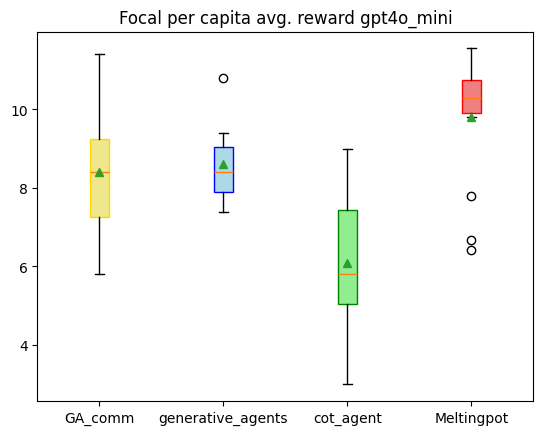

In [15]:
rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, agents_mean)
rewards_results['Meltingpot'] = [
    10.28994709,
    10.1135376,
    10.39208633,
    10.76997539,
    10.7430223,
    11.55376261,
    10.67341772,
    10.00926984,
    9.814327657,
    10.11118922,
    6.675783972,
    6.410152838,
    7.794463668,
    10.746139,
    11.05280289
]

title = 'Focal per capita avg. reward gpt4o_mini'
subcat_colors = [{'facecolor': 'khaki', 'color': 'gold'}] + SUBCAT_COLORS + [{'facecolor': 'lightcoral', 'color': 'red'}]
create_box_plot(rewards_results, subcat_colors, title=title)

T-tests between architecture results

In [16]:
from scipy.stats import t
import math

archs = list(rewards_results.keys())

def calculate_sig_of_diff(results1, results2, lower_tail=False):
    se1 = np.var(results1, ddof=1)/len(results1)
    se2 = np.var(results2, ddof=1)/len(results2)
    t_score = (np.mean(results1) - np.mean(results2))/np.sqrt(se1 + se2)
    df = (se1**2  + se2**2)** 2 / (se1**4/(len(results1)-1) + se2**4/(len(results2)-1))
    df = math.floor(df)

    if lower_tail:
        p = t.cdf(t_score, df)
    else:
        p = 1 - t.cdf(t_score, df)
    return t_score, p

for i in range(len(archs)):
    for j in range(i+1, len(archs)):
        t_score, p = calculate_sig_of_diff(rewards_results[archs[i]], rewards_results[archs[j]])
        print(f'{archs[i]} vs {archs[j]}: t={t_score}, p={p}')

GA_comm vs generative_agents: t=-0.23369135731865756, p=0.5877544104221004
GA_comm vs cot_agent: t=2.362515003022758, p=0.02507768847460423
GA_comm vs Meltingpot: t=-1.5786964122390281, p=0.9123809546211044
generative_agents vs cot_agent: t=3.90011856540661, p=0.0014802187958927737
generative_agents vs Meltingpot: t=-2.369326648689328, p=0.9862592873818541
cot_agent vs Meltingpot: t=-5.376586369460129, p=0.9999369488749669


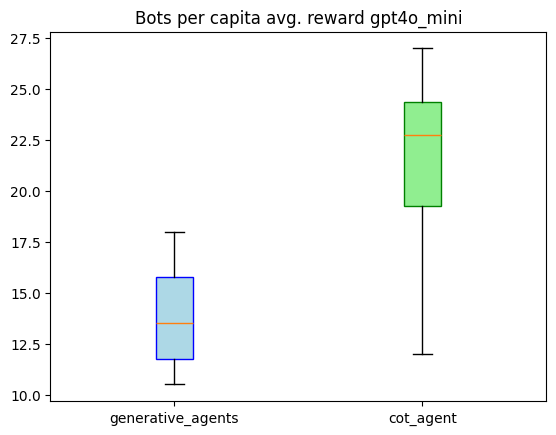

In [24]:
rewards_results = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, None, bots_mean)

title = 'Bots per capita avg. reward gpt4o_mini'
create_box_plot(rewards_results, SUBCAT_COLORS, title=title)

## Gini coefficient

In [25]:
def take_cat_result(actions_indicator_by_sim, category):
        # If there is no category, return the results for Juan
        if category is None:
                return actions_indicator_by_sim

        return [sim[category] if category in sim else 0 for sim in actions_indicator_by_sim]

In [26]:
agents = ['Angie', 'David', 'Juan', 'Laura', 'Pedro', 'bot_1', 'bot_2']
reward_by_agent_by_arch = get_results_by_category_and_subcategory(rewards, 'gpt4o_mini', None, agents, take_cat_result)

In [27]:
# Calculate the gini coefficient
def gini(x):
    """
    Calculate the Gini coefficient of a numpy array.

    Parameters:
    x (numpy array): The array with the values, wher
    """
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [28]:
gini_coefs1 = []
reward_by_agent_arch1 = [agent_result['generative_agents'] for agent_result in reward_by_agent_by_arch.values()]
for sim in range(len(reward_by_agent_arch1[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch1]
    gini_coefs1.append(gini(rewards_by_agent))

gini_coefs2 = []
reward_by_agent_arch2 = [agent_result['cot_agent'] for agent_result in reward_by_agent_by_arch.values()]
for sim in range(len(reward_by_agent_arch2[0])):
    rewards_by_agent = [agent[sim] for agent in reward_by_agent_arch2]
    gini_coefs2.append(gini(rewards_by_agent))

gini_coefs_by_arch = {'generative_agents': gini_coefs1, 'cot_agent': gini_coefs2}

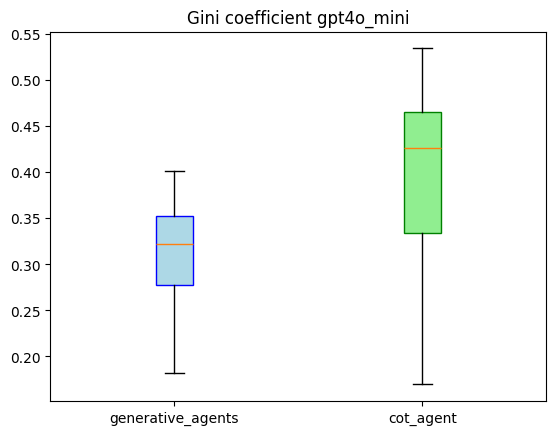

In [29]:
create_box_plot(gini_coefs_by_arch, SUBCAT_COLORS, title='Gini coefficient gpt4o_mini')

In [30]:
archs = list(gini_coefs_by_arch.keys())

for i in range(len(archs)):
    for j in range(i+1, len(archs)):
        t_score, p = calculate_sig_of_diff(gini_coefs_by_arch[archs[i]], gini_coefs_by_arch[archs[j]], lower_tail=True)
        print(f'{archs[i]} vs {archs[j]}: t={t_score}, p={p}')

generative_agents vs cot_agent: t=-2.013989283435876, p=0.03456290273221824


## Custom indicators for the scenario

First, get all the indicators' results for each model.

The file structure for the scenario simulations should be the following:
* agent_architecture
    * llm_model
        * simulations


The indicators will be held in a dictionary with the following structure:
`{agent_architecture: {llm_model: [simulation_1_indicators,]}}`

In [31]:
indicators = {}
# Get the list of agents architectures
LAAs_models = os.listdir(folder)
# Iterate over the agents architectures
for model in LAAs_models:
    model_path = os.path.join(folder, model)
    # Get the list of LLMs
    llm_models = os.listdir(model_path)

    indicators[model] = {}

    # Iterate over the LLMs per agent architecture
    for llm_model in llm_models:
        # Get the list of simulations per LLM and agent architecture
        llm_model_path = os.path.join(model_path, llm_model)

        indicators[model][llm_model] = []

        # Iterate over the simulations
        for sim_folder in os.listdir(llm_model_path):
            # skip if it is not a folder
            if not os.path.isdir(os.path.join(llm_model_path, sim_folder)):
                continue

            # Load the indicators
            indicators_per_sim = os.path.join(llm_model_path, sim_folder, indicators_filename)
            with open(indicators_per_sim, 'r') as file:
                indicators_per_sim = json.load(file)

            # Add the indicators to the global dictionary
            indicators[model][llm_model].append(indicators_per_sim)

In [32]:
def get_indicator_by_simulation(indicators, indicator_name):
    """
    Returns a list with the value of the indicator scpecified for each simulation
    """
    return [sim[indicator_name] if indicator_name in sim else {} for sim in indicators]

### Actions taken by the LLM

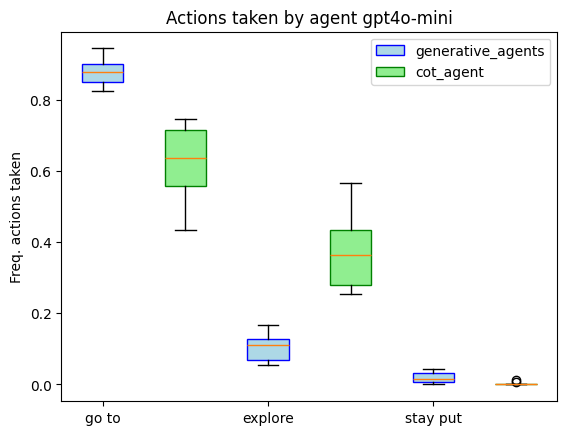

In [33]:
title = 'Actions taken by agent gpt4o-mini'
ylabel = 'Freq. actions taken'
actions_taken = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'actions_taken', ['go to', 'explore', 'stay put'], agents_mean)
create_box_plot(actions_taken, SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)
                

### portion_move_towards_last_apple

portion_move_towards_last_apple for the agents

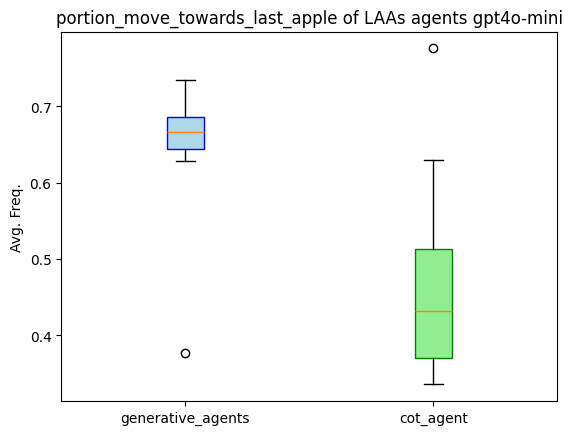

In [34]:
mushroom_type_consumption = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'portion_move_towards_last_apple', None, agents_mean)
title = 'portion_move_towards_last_apple of LAAs agents gpt4o-mini'
ylabel = 'Avg. Freq.'
create_box_plot(mushroom_type_consumption, SUBCAT_COLORS, norm_across_cats=True, title=title, ylabel=ylabel)

portion_move_towards_last_apple of bots

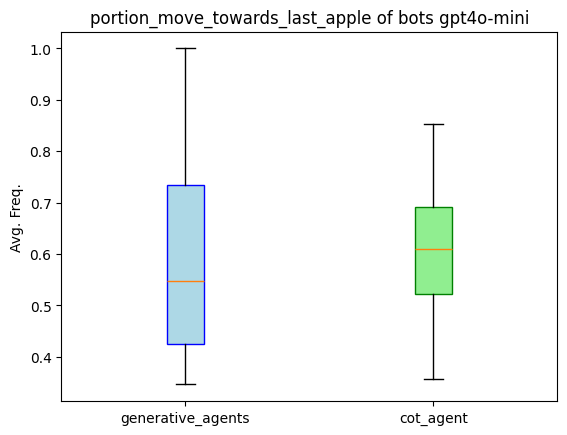

In [35]:
mushroom_type_consumption = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'portion_move_towards_last_apple', None, bots_mean)
title = 'portion_move_towards_last_apple of bots gpt4o-mini'
ylabel = 'Avg. Freq.'
create_box_plot(mushroom_type_consumption, SUBCAT_COLORS, title=title, ylabel=ylabel)

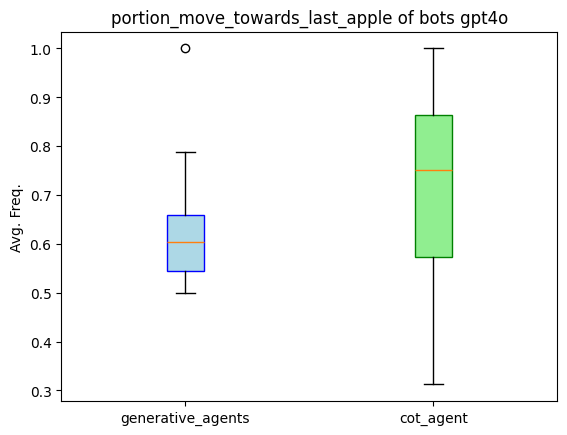

In [34]:
mushroom_type_consumption = get_results_by_category_and_subcategory(indicators, 'gpt4o', 'portion_move_towards_last_apple', None, bots_mean)
title = 'portion_move_towards_last_apple of bots gpt4o'
ylabel = 'Avg. Freq.'
create_box_plot(mushroom_type_consumption, SUBCAT_COLORS, title=title, ylabel=ylabel)

### Who took the last apple

times_took_last_apple agents

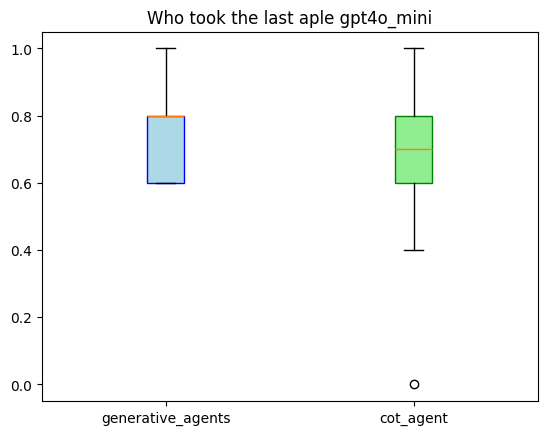

In [36]:
digesting_spent_time = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'times_took_last_apple', None, agents_mean)
title = 'Who took the last aple gpt4o_mini'
ylabel = 'Avg. Freq.'
create_box_plot(digesting_spent_time, SUBCAT_COLORS, title=title)

### Time they attacked

In [43]:
agents = ['Angie', 'David', 'Juan', 'Laura', 'Pedro', 'bot_1', 'bot_2']
times_attack = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'times_decide_to_attack', agents, take_cat_result)

In [44]:
def group_results_by_category_group(results, category_groups, subcategories):
    # The category_groups is a dictionary with the group name as key and a list with the categories names as values
    grouped_results = {}
    for group in category_groups.keys():
        grouped_results[group] = {}
        for s in subcategories:
            grouped_results[group][s] = []
            for c in category_groups[group]:
                # Results for each category are concatenated, so each group will have simulations*categories_per_group data
                grouped_results[group][s] += results[c][s]
    
    # The data has the same structure as the original data, but the categories
    return grouped_results

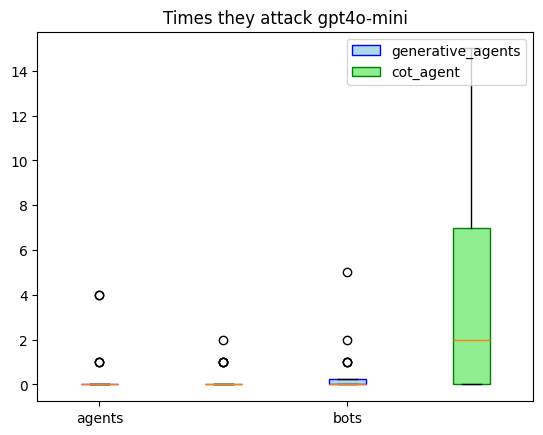

In [45]:
subcategories = list(times_attack[agents[0]].keys())

new_cats = {
    'agents': [
        'Angie',
        'David',
        'Juan',
        'Laura',
        'Pedro'
    ],
    'bots': [
        'bot_1',
        'bot_2'
    ]
}

title = 'Times they attack gpt4o-mini'

times_attack = group_results_by_category_group(times_attack, new_cats, subcategories)
create_box_plot(times_attack, SUBCAT_COLORS, title=title)

## Times the attack is effective

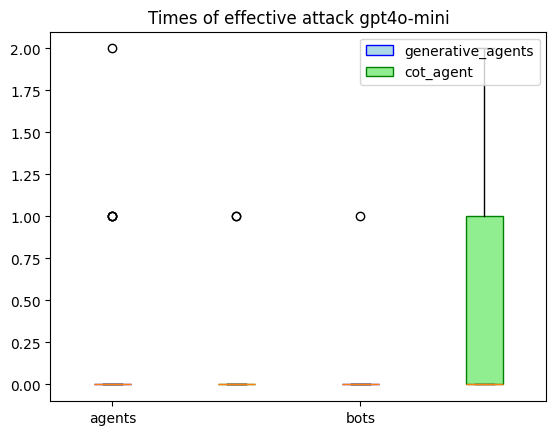

In [46]:
agents = ['Angie', 'David', 'Juan', 'Laura', 'Pedro', 'bot_1', 'bot_2']
effective_attack = get_results_by_category_and_subcategory(indicators, 'gpt4o_mini', 'effective_attack', agents, take_cat_result)

subcategories = list(effective_attack[agents[0]].keys())

new_cats = {
    'agents': [
        'Angie',
        'David',
        'Juan',
        'Laura',
        'Pedro'
    ],
    'bots': [
        'bot_1',
        'bot_2'
    ]
}

title = 'Times of effective attack gpt4o-mini'

effective_attack = group_results_by_category_group(effective_attack, new_cats, subcategories)
create_box_plot(effective_attack, SUBCAT_COLORS, title=title)